In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv("online_sales_dataset.csv")

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00,1.71,37039.0,Australia,0.470000,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00,41.25,19144.0,Spain,0.190000,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00,29.11,50472.0,Germany,0.350000,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00,76.68,96586.0,Netherlands,0.140000,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low
4,359178,SKU_1386,USB Cable,-30,2020-01-01 04:00,-68.11,NaN,United Kingdom,1.501433,Bank Transfer,NaN,Electronics,In-store,Not Returned,FedEx,NaN,Medium


In [36]:
df.isnull().sum()

InvoiceNo               0
StockCode               0
Description             0
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID           4978
Country                 0
Discount                0
PaymentMethod           0
ShippingCost         2489
Category                0
SalesChannel            0
ReturnStatus            0
ShipmentProvider        0
WarehouseLocation    3485
OrderPriority           0
dtype: int64

In [37]:
df.duplicated().any()

False

In [38]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Discount', 'PaymentMethod',
       'ShippingCost', 'Category', 'SalesChannel', 'ReturnStatus',
       'ShipmentProvider', 'WarehouseLocation', 'OrderPriority'],
      dtype='object')

In [39]:
#Biến số rời rạc (Discrete variables): InvoiceNo, Quantity, và CustomerID có thể được xem là các biến rời rạc.
#Biến số liên tục (Continuous variables): UnitPrice, Discount, và ShippingCost.
#Biến phân loại (Categorical variables): StockCode, Description, Country, PaymentMethod, Category, SalesChannel, ReturnStatus, ShipmentProvider, WarehouseLocation, và OrderPriority.

In [40]:
#Phan tich tuong quan
correlation = df.corrwith(df['Quantity'])
print(correlation.sort_values(ascending=False))

Quantity        1.000000
UnitPrice       0.241028
CustomerID      0.002889
ShippingCost   -0.004086
InvoiceNo      -0.004980
Discount       -0.290293
dtype: float64


In [41]:
df['WarehouseLocation'].fillna(df['WarehouseLocation'].mode()[0], inplace=True)  # Fill null với giá trị mode
df['ShippingCost'].fillna(df['ShippingCost'].mean(), inplace=True)  # Fill null với giá trị mean

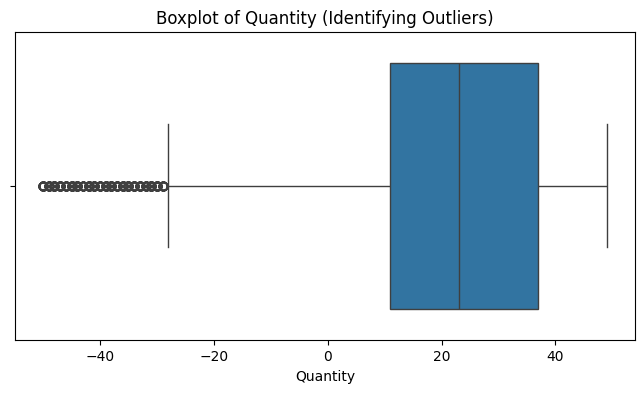

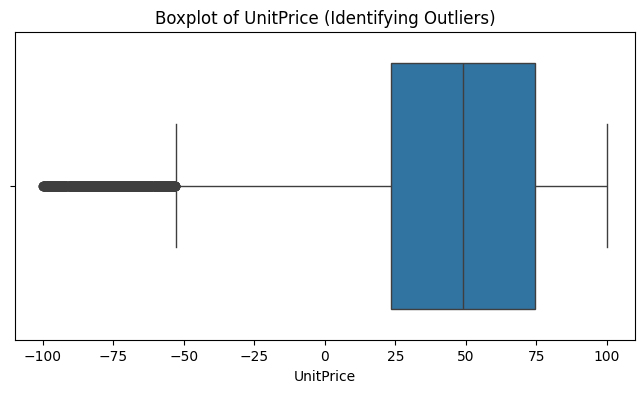

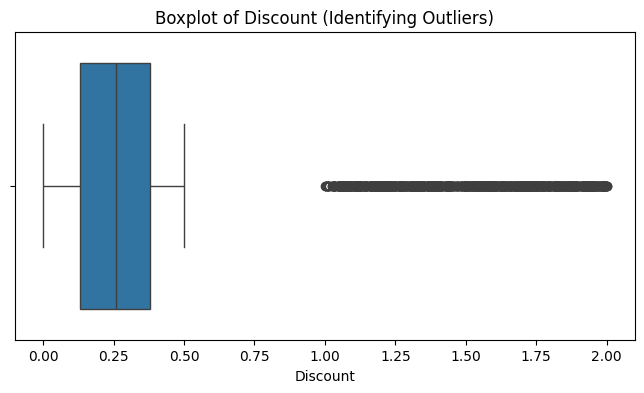

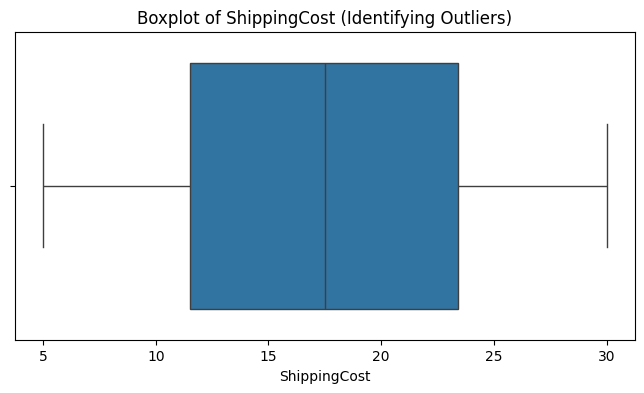

In [42]:
#Kiểm tra outlier
for var in ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var} (Identifying Outliers)')
    plt.xlabel(var)
    plt.show()

In [43]:
#Quantity và UnitPrice có một số giá trị nằm ngoài phạm vi râu của hộp, cho thấy sự xuất hiện của ngoại lệ.
#Discount có một vài giá trị cao bất thường.
#ShippingCost không có nhiều ngoại lệ rõ ràng, nhưng có một số giá trị xa trung tâm.

In [44]:
#Xóa bỏ outlier
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [45]:
#Xóa bỏ outlier 
df_cleaned = remove_outliers_iqr(df, ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost'])

In [46]:
#Tạo các đặc trưng
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['Revenue'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
df_cleaned['DayOfWeek'] = df_cleaned['InvoiceDate'].dt.dayofweek
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Quarter'] = df_cleaned['InvoiceDate'].dt.quarter

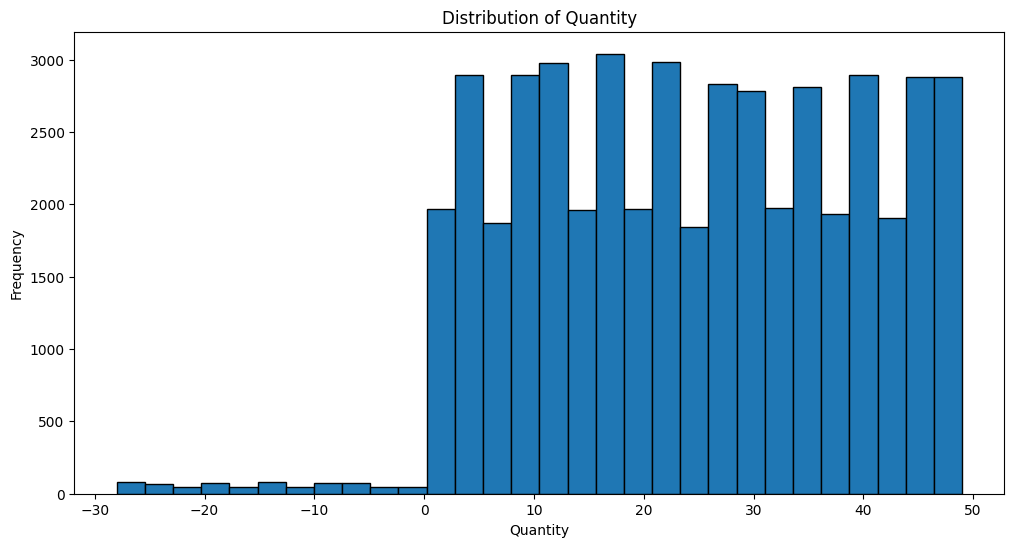

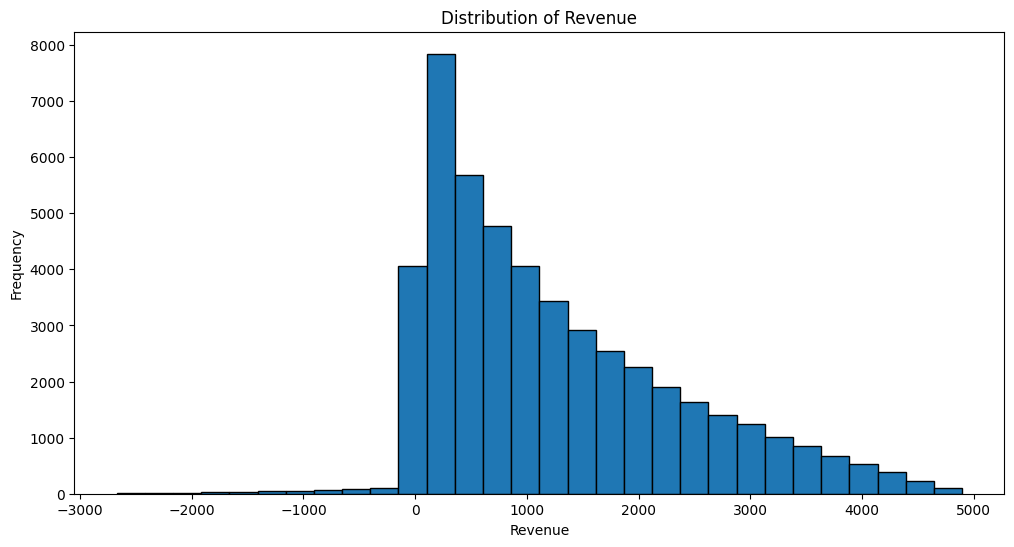

In [47]:
#Trực quan hóa Quantity và Revenue
plt.figure(figsize=(12, 6))
plt.hist(df_cleaned['Quantity'], bins=30, edgecolor='black')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df_cleaned['Revenue'], bins=30, edgecolor='black')
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()



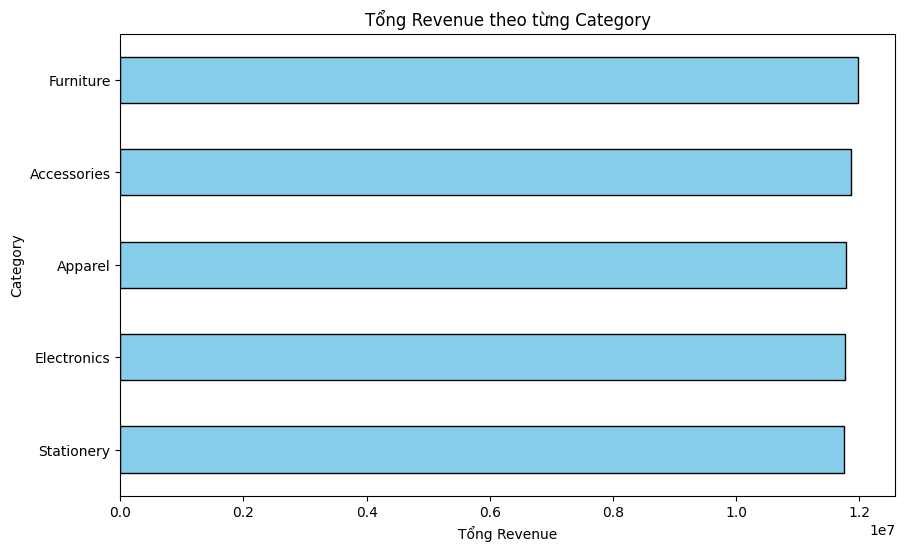

In [48]:
# Trực quan hóa Tổng Revenue theo từng Category
plt.figure(figsize=(10, 6))
category_revenue = df_cleaned.groupby('Category')['Revenue'].sum().sort_values()
category_revenue.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Tổng Revenue theo từng Category')
plt.xlabel('Tổng Revenue')
plt.ylabel('Category')
plt.show()


In [49]:
#Tổng hợp dữ liệu theo Quý và Danh mục để dự báo
quarterly_demand = df_cleaned.groupby(['Year', 'Quarter', 'Category']).agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('Revenue', 'sum'),
    AvgDiscount=('Discount', 'mean'),
    AvgShippingCost=('ShippingCost', 'mean'),
    TotalTransactions=('InvoiceNo', 'nunique')
).reset_index()

# Hiển thị dữ liệu tổng hợp theo quý
quarterly_demand.head()

,Year,Quarter,Category,TotalQuantity,TotalRevenue,AvgDiscount,AvgShippingCost,TotalTransactions
0,2020,1,Accessories,9968,501264.19,0.250364,17.324475,412
1,2020,1,Apparel,10294,512062.46,0.256085,17.775334,424
2,2020,1,Electronics,11010,541261.87,0.244385,17.665564,447
3,2020,1,Furniture,9689,470361.67,0.256090,17.352075,399
4,2020,1,Stationery,10898,538174.73,0.243598,16.766211,428


In [50]:
numeric_df = quarterly_demand.select_dtypes(include=['number'])
# Tính toán hệ số tương quan của TotalQuantity với các cột khác
correlation = numeric_df.corrwith(quarterly_demand['TotalQuantity'])
print(correlation.sort_values(ascending=False))

TotalQuantity        1.000000
TotalRevenue         0.929241
TotalTransactions    0.926254
AvgDiscount          0.101163
Quarter              0.010168
AvgShippingCost     -0.101311
Year                -0.302498
dtype: float64
